In [1]:
# optional: run this block to adjust the width of the notebook.  Change the width percent.

from  IPython.core.display  import  display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook
import sys, os

# v edit this line
sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas/')
# ^ edit this line

from metatlas.tools import fastanalysis as fa
from metatlas.plots import dill2plots as dp
from metatlas.io import metatlas_get_data_helper_fun as ma_data
from metatlas.plots import chromplotplus as cpp
from metatlas.datastructures import metatlas_objects as metob
import qgrid
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
import time
import pickle
import dill
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import operator

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)

('NERSC=', True)


/global/homes/b/bpb/repos/metatlas/metatlas/datastructures/object_helpers.py:135: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  nersc_info = yaml.load(fid)


In [2]:
output_dir = '/global/homes/b/bpb/Downloads/test_metatlas'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
atlas_filename = 'atlas.csv' 
atlas_dbname = 'tempatlas'
group_dbname = '%20180502_KBL%POS%sweetpotato%raw%'
fileinfo_filename = 'fileinfo.tab'

In [3]:
files = metob.retrieve('lcmsruns',name=group_dbname,username='*')
for f in files:
    print(f.name,f.username)

20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_3_SP-R_2_Rg80to1200-CE102040-sweetpotato-raw-S1_Run98.mzML bpb
20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_1_SP-R_0_Rg80to1200-CE102040-sweetpotato-raw-S1_Run47.mzML bpb
20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_2_SP-R_1_Rg80to1200-CE102040-sweetpotato-raw-S1_Run65.mzML bpb
20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_4_SP-R_3_Rg80to1200-CE205060-sweetpotato-raw-S1_Run137.mzML bpb
20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_2_SP-R_1_Rg80to1200-CE102040-sweetpotato-raw-S1_Run65.mzML kblouie
20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_1_SP-R_0_Rg80to1200-CE102040-sweetpotato-raw-S1_Run47.mzML kblouie
20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_4_SP-R_3_Rg80to1200-CE205060-sweetpotato-raw-S1_Run137.mzML kblouie
20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_3_SP-R_2_Rg80to1200-CE102040-sweetpotato-raw-S1_Run98.mzML kblouie
20180502_KBL_P

In [4]:
files = dp.get_metatlas_files(experiment='20180502_KBL_C18_PT_SwtPotVeggies',name = group_dbname,most_recent = True)
len(files)
# ^ edit the text string in experiment and name fields

df = metob.to_dataframe(files)
# my_grid = qgrid.QGridWidget(df=df[['experiment','name','username','acquisition_time']])
# my_grid.export()


In [5]:
#STEP 1: View the groups

files = metob.retrieve('lcmsruns',experiment='20180502_KBL_C18_PT_SwtPotVeggies',name = group_dbname,username='*')
controlled_vocab = ['QC','InjBl','ISTD'] #add _ to beginning. It will be stripped if at begining
version_identifier = 'vrs3'
file_dict = {}
groups_dict = {}
for f in files:
    k = f.name.split('.')[0]
    #     get index if any controlled vocab in filename
    indices = [i for i, s in enumerate(controlled_vocab) if s.lower() in k.lower()]
    prefix = '_'.join(k.split('_')[:11])
    if len(indices)>0:
        short_name = controlled_vocab[indices[0]].lstrip('_')
        group_name = '%s_%s_%s'%(prefix,version_identifier,short_name)
        short_name = k.split('_')[9]+'_'+short_name # Prepending POL to short_name
    else:
        short_name = k.split('_')[12]
        group_name = '%s_%s_%s'%(prefix,version_identifier,short_name)
        short_name = k.split('_')[9]+'_'+k.split('_')[12]  # Prepending POL to short_name
    file_dict[k] = {'file':f,'group':group_name,'short_name':short_name}
    groups_dict[group_name] = {'items':[],'name':group_name,'short_name':short_name}
df = pd.DataFrame(file_dict).T
df.index.name = 'filename'
df.reset_index(inplace=True)#['group'].unique()
df.drop(columns=['file'],inplace=True)
for ug in groups_dict.keys():
    for file_key,file_value in file_dict.items():
        if file_value['group'] == ug:
            groups_dict[ug]['items'].append(file_value['file'])


In [6]:
#STEP 2: create the groups variable, if the above looks OK

groups = []
for group_key,group_values in groups_dict.items():
    g = metob.Group(name=group_key,items=group_values['items'],short_name=group_values['short_name'])
    groups.append(g)        
    for item in g.items:
        print(g.name,g.short_name,item.name)
    print('')

# STEP 3 Option A: store the groups variable content in the DB (currently only the long group name is stored)
# metob.store(groups)


20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_vrs3_SP-R POS_SP-R 20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_3_SP-R_2_Rg80to1200-CE102040-sweetpotato-raw-S1_Run98.mzML
20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_vrs3_SP-R POS_SP-R 20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_1_SP-R_0_Rg80to1200-CE102040-sweetpotato-raw-S1_Run47.mzML
20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_vrs3_SP-R POS_SP-R 20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_2_SP-R_1_Rg80to1200-CE102040-sweetpotato-raw-S1_Run65.mzML
20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_vrs3_SP-R POS_SP-R 20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_4_SP-R_3_Rg80to1200-CE205060-sweetpotato-raw-S1_Run137.mzML



In [7]:
#STEP 1: Select files
files = dp.get_metatlas_files(experiment='20180502_KBL_C18_PT_SwtPotVeggies',name = group_dbname,most_recent = True)
# ^ edit the text string in experiment and name fields


In [8]:
#STEP 2: Save spreadsheet file
dp.make_empty_fileinfo_sheet('%s%s' % (output_dir,'empty_fileinfo.tab'),files)


In [9]:
# #STEP 3: create groups from file
# g = dp.make_groups_from_fileinfo_sheet('%s%s' % (output_dir,'filled_fileinfo.txt'),
#                                        filetype='tab',
#                                        store=False)

In [10]:
# STEP 4: check groups

metob.to_dataframe(groups)

,creation_time,description,items,last_modified,name,short_name,unique_id,username
0,2020-10-26 19:00:20,None,"[7744424d2d99409fb1eef8db55928876, 8c319ab7006640caa1953de71fbfc729, 1e9030dccb4a4e9685da0fbfc00...",2020-10-26 19:00:20,20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_vrs3_SP-R,POS_SP-R,3509b615978949c58f0d808ced07c8b4,bpb


In [11]:
# Make short_filename and short_samplename 
files = metob.retrieve('lcmsruns',experiment='20180502_KBL_C18_PT_SwtPotVeggies',name = group_dbname,username='vrsingan')
short_filename_delim_ids = [0,2,4,5,7,9,14]
short_samplename_delim_ids = [9,12,13,14]
short_names_df = pd.DataFrame(columns=['sample_treatment','short_filename','short_samplename'])
ctr = 0
for f in files:
    short_filename = []
    short_samplename = []
    tokens = f.name.split('.')[0].split('_')
    for id in short_filename_delim_ids:
        short_filename.append(str(tokens[id]))
    for id in short_samplename_delim_ids:
        short_samplename.append(str(tokens[id]))
    short_filename = "_".join(short_filename)
    short_samplename = "_".join(short_samplename)
    short_names_df.loc[ctr, 'full_filename'] = f.name.split('.')[0]
    short_names_df.loc[ctr, 'sample_treatment'] = str(tokens[12]) # delim 12
    short_names_df.loc[ctr, 'short_filename'] = short_filename
    short_names_df.loc[ctr, 'short_samplename'] = short_samplename
    ctr +=1
short_names_df.set_index('full_filename', inplace=True)
short_names_df.to_csv(os.path.join(output_dir, 'short_names.csv'), sep='\t', index=True)

In [12]:
# Optional import edited short_names.csv 
short_names_df = pd.read_csv(os.path.join(output_dir, 'short_names.csv'), sep='\t', index_col='full_filename')

In [13]:
groups = dp.select_groups_for_analysis(name = '20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_vrs3_SP-R',    # <- edit text search string here
                                       most_recent = True,
                                       remove_empty = True,
                                       include_list = [], exclude_list = [])# ex. ['QC','Blank'])
print("sorted groups")
groups = sorted(groups, key=operator.attrgetter('name'))
for i,a in enumerate(groups):
    print(i, a.name)

1
(0, '20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_vrs3_SP-R', datetime.datetime(2020, 10, 22, 17, 13, 18))
sorted groups
0 20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_vrs3_SP-R


In [14]:
# to view metadata about your groups, run the block below
metob.to_dataframe(groups)

,creation_time,description,items,last_modified,name,short_name,unique_id,username
0,2020-10-22 17:13:18,No description,"[7744424d2d99409fb1eef8db55928876, 8c319ab7006640caa1953de71fbfc729, 70025b437a1542f1920150d073f...",2020-10-22 17:13:18,20180502_KBL_PT_SwtPot_CkVsRw_MVeg_QE-HF_C18_105_POS_MSMS_vrs3_SP-R,POS_SP-R,c5585a41987f40069a11fc923782fc31,bpb


In [17]:
atlases = metob.retrieve('Atlas',name=atlas_dbname,username='bpb')
names = []
for i,a in enumerate(atlases):
    print(i,a.name,pd.to_datetime(a.last_modified,unit='s'))#len(a.compound_identifications)

0 tempatlas 2020-10-22 17:23:37
1 tempatlas 2020-10-22 17:36:51
2 tempatlas 2020-10-22 17:46:12


In [18]:
my_atlas = atlases[-1]
atlas_df = ma_data.make_atlas_df(my_atlas)
atlas_df['label'] = [cid.name for cid in my_atlas.compound_identifications]
print(my_atlas.name)
metob.to_dataframe([my_atlas])
# the first line of the output will show the dimensions of the atlas dataframe

((42, 15), 42)
tempatlas


,compound_identifications,creation_time,description,last_modified,name,unique_id,username
0,"[6504e291f343476d83330d894cfb365a, 083934c302294d24afbcf405daf226b0, aef7397e353149e6bca031948da...",2020-10-22 17:46:12,No description,2020-10-22 17:46:12,tempatlas,e16de4a5557043b381d2818dd07e1ef6,bpb


In [23]:
all_files = []
for my_group in groups:
    for my_file in my_group.items:
        extra_time = 0.1  
        extra_mz = 0.00
        all_files.append((my_file,my_group,atlas_df,my_atlas,extra_time,extra_mz))
pool = mp.Pool(processes=min(4, len(all_files)))
t0 = time.time()
metatlas_dataset = pool.map(ma_data.get_data_for_atlas_df_and_file, all_files)
pool.close()
pool.terminate()
print(time.time() - t0)

/ms1_neg (0, 3)
/ms1_neg (0, 3)
/ms1_neg (0, 3)
/ms1_neg (0, 3)
/ms1_pos (2945397, 3)
/ms2_neg (0, 6)/ms1_pos
 (2926438, 3)
/ms2_neg (0, 6)
/ms2_pos (127169, 6)
/ms1_pos (2883554, 3)
/ms2_pos (123638, 6)
/ms2_neg /ms1_pos (0, 6)(2911349, 3)

/ms2_neg (0, 6)
/ms2_pos (133030, 6)
/ms2_pos (129634, 6)
1.7299983501434326


In [25]:
# Make data sources tables (atlas_metadata.tab, groups_metadata.tab, groups.tab and [atlasname]_originalatlas.tab within data_sources subfolder)
ma_data.make_data_sources_tables(groups, my_atlas, output_dir)

((42, 15), 42)


In [26]:
num_data_points_passing = 3
peak_height_passing = 1e4
rt_peak_passing = 0.8
atlas_df_passing = dp.filter_atlas(atlas_df=atlas_df, input_dataset=metatlas_dataset, num_data_points_passing = num_data_points_passing, peak_height_passing = peak_height_passing, rt_peak_passing = rt_peak_passing)
print("# Compounds in Atlas: "+str(len(atlas_df)))
print("# Compounds passing filter: "+str(len(atlas_df_passing)))

# Compounds in Atlas: 42
# Compounds passing filter: 35


In [27]:
##BLOCK A
t0 = time.time()

hits=dp.get_msms_hits(metatlas_dataset,extra_time=True,keep_nonmatches=True,ref_loc='/global/project/projectdirs/metatlas/projects/spectral_libraries/msms_refs_v4.tab',)
pickle.dump(hits, open(os.path.join(output_dir,'hits.pkl'), "wb"))

print(time.time() - t0)
print('%s%s' % (len(hits),' <- total number of MSMS spectra found in your files'))

Processing: 9 / 42 compounds.

/global/homes/b/bpb/repos/metatlas/metatlas/plots/dill2plots.py:2165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['spectrum'] = ref_df['spectrum'].apply(lambda s: eval(s)).apply(np.array)


Processing: 42 / 42 compounds.
Done!!!23.94299626350403
273 <- total number of MSMS spectra found in your files


In [41]:
from importlib import reload
dp = reload(dp)

<IPython.core.display.Javascript object>


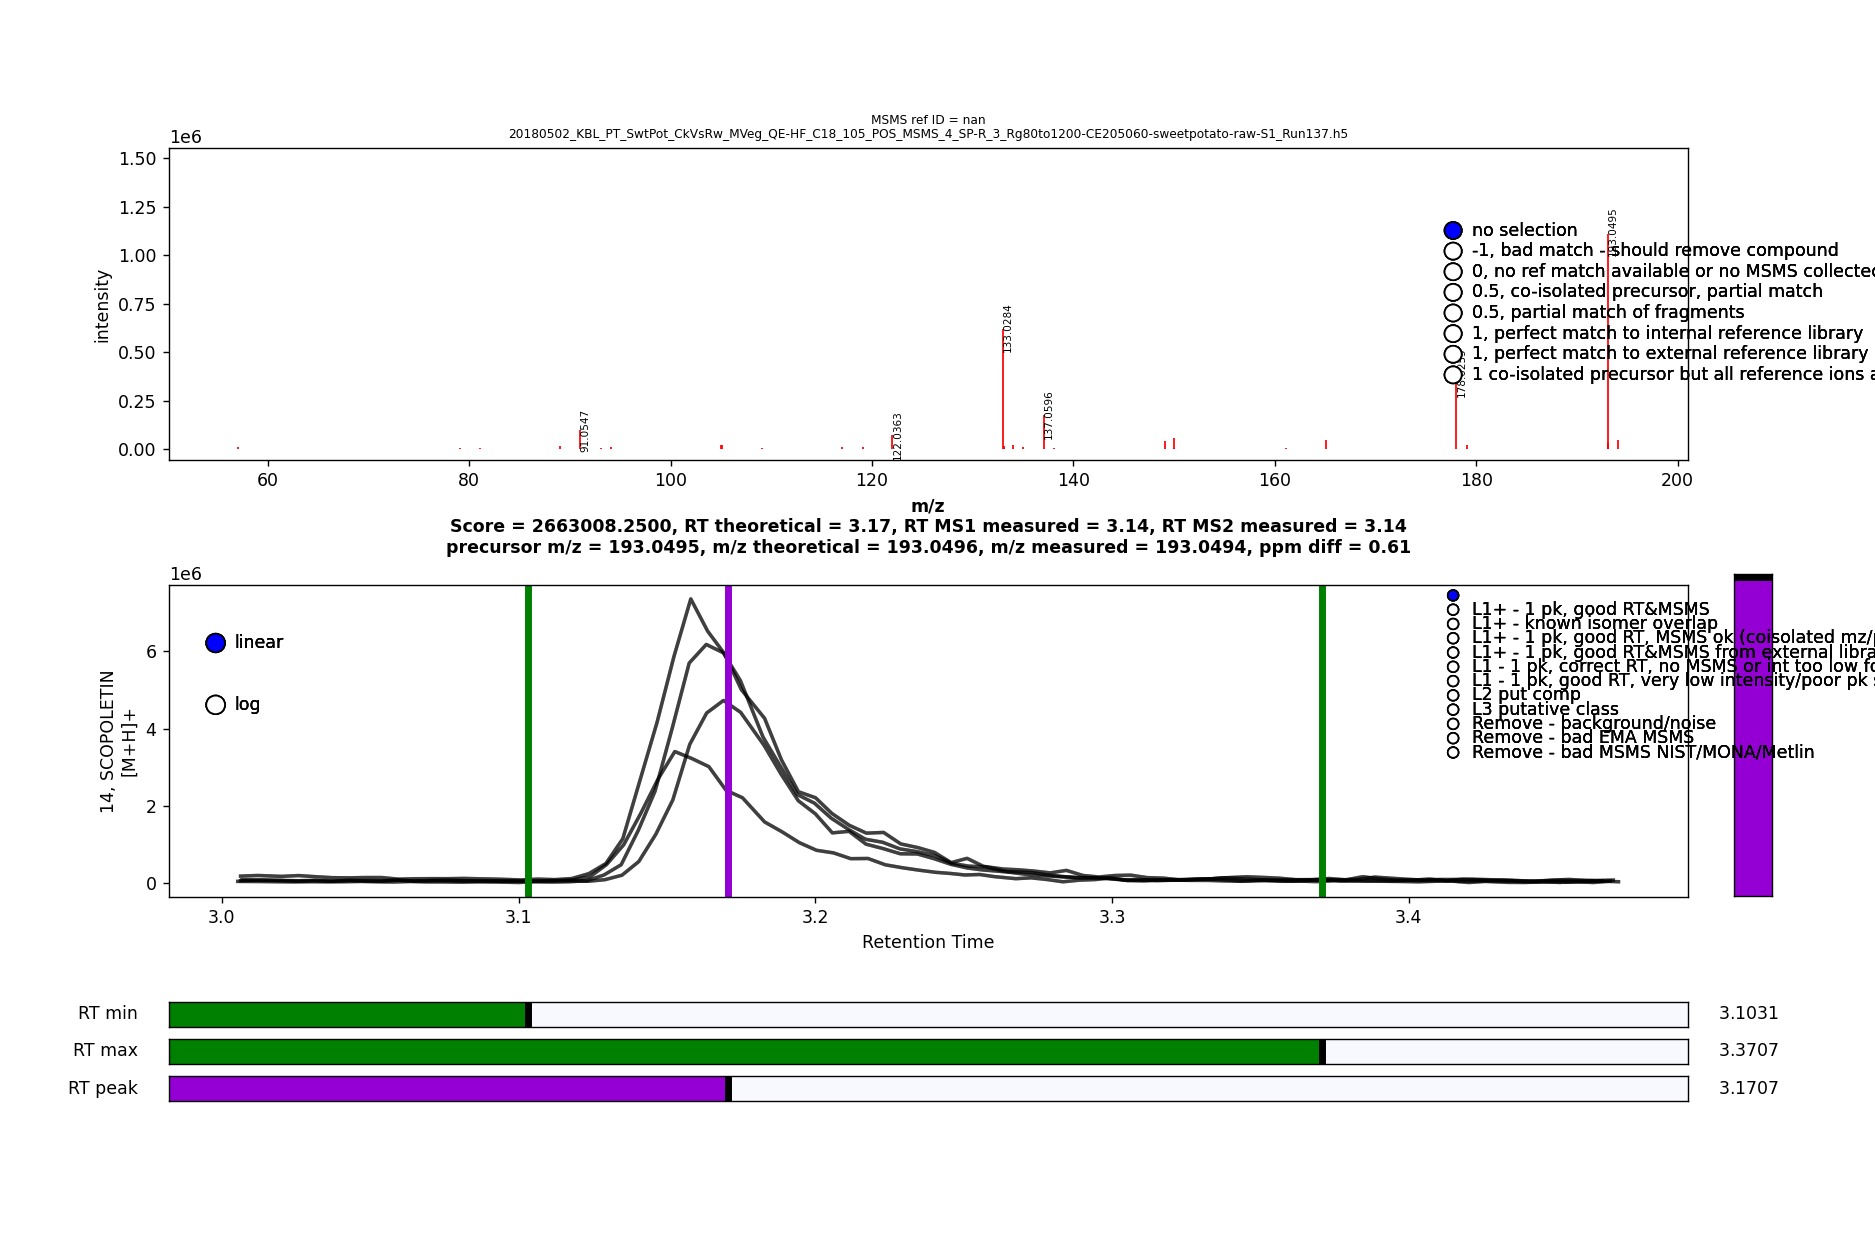

('loaded file for username = ', 'bpb')


/global/homes/b/bpb/repos/metatlas/metatlas/plots/dill2plots.py:551: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  self.ax.plot(x,y,'k-',zorder=1,linewidth=2.0,alpha=self.alpha, picker=5, label = d[self.compound_idx]['lcmsrun'].name.replace('.mzML',''))
/global/homes/b/bpb/repos/metatlas/metatlas/plots/dill2plots.py:551: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  self.ax.plot(x,y,'k-',zorder=1,linewidth=2.0,alpha=self.alpha, picker=5, label = d[self.compound_idx]['lcmsrun'].name.replace('.mzML',''))
/global/homes/b/bpb/repos/metatlas/metatlas/plots/dill2plots.py:551: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradiu

In [42]:
###STEP 1: Set the peak flag radio buttons using one of the two lines below, for custom flags or default flags

peak_flag_list=('','L1+ - 1 pk, good RT&MSMS','L1+ - known isomer overlap','L1+ - 1 pk, good RT, MSMS ok (coisolated mz/partial match/low int)','L1+ - 1 pk, good RT&MSMS from external library','L1 - 1 pk, correct RT, no MSMS or int too low for matching','L1 - 1 pk, good RT, very low intensity/poor pk shape','L2 put comp','L3 putative class','Remove - background/noise','Remove - bad EMA MSMS','Remove - bad MSMS NIST/MONA/Metlin')
#peak_flag_list =""       # this will default to ('keep','remove','unresolvable isomers','poor peak shape')

###STEP 2: Set the EIC line colors using on of the two lines below, for custom colors or default 
colorlist= [['red','peas'],                                                     
           ['green','beets']]
#colorlist=""   # this will default to black

###STEP 3
a = dp.adjust_rt_for_selected_compound(metatlas_dataset, msms_hits=hits,peak_flags=peak_flag_list, color_me = colorlist, compound_idx=12,alpha=0.5,width=15,height=4.5)


In [29]:
atlas_identifications = dp.export_atlas_to_spreadsheet(my_atlas,os.path.join(output_dir,'%s%s.csv' % (my_atlas.name,"export")))
print(my_atlas.name)

tempatlas


In [30]:
kwargs = {'min_intensity': 1e4,   # strict = 1e5, loose = 1e3
          'rt_tolerance': .5,    #>= shift of median RT across all files for given compound to reference
          'mz_tolerance': 20,      # strict = 5, loose = 25; >= ppm of median mz across all files for given compound relative to reference
          'min_msms_score': .6, 'allow_no_msms': True,     # strict = 0.6, loose = 0.3 <= highest compound dot-product score across all files for given compound relative to reference
          'min_num_frag_matches': 1, 'min_relative_frag_intensity': .001}   # strict = 3 and 0.1, loose = 1, 0.01 number of matching mzs when calculating max_msms_score and ratio of second highest to first highest intensity of matching sample mzs
scores_df = fa.make_scores_df(metatlas_dataset,hits)
scores_df['passing'] = fa.test_scores_df(scores_df, **kwargs)

pass_atlas_df, fail_atlas_df, pass_dataset, fail_dataset = fa.filter_atlas_and_dataset(scores_df, atlas_df, metatlas_dataset, column='passing')

fa.make_stats_table(input_dataset = metatlas_dataset, msms_hits = hits, output_loc = output_dir,min_peak_height=1e5,use_labels=True,min_msms_score=0.01,min_num_frag_matches=1,include_lcmsruns = [],exclude_lcmsruns = ['QC'])
scores_df.to_csv(os.path.join(output_dir, 'stats_tables','compound_scores.csv'))

/global/common/software/m2650/python3-metatlas-cori/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/global/common/software/m2650/python3-metatlas-cori/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/m2650/python3-metatlas-cori/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
group = 'index' # 'page' or 'index' or None
save = True
share_y = True

dp.make_chromatograms(input_dataset=metatlas_dataset, group=group, share_y=share_y, save=save, output_loc=output_dir, short_names_df=short_names_df, short_names_header='short_samplename')

/global/homes/b/bpb/repos/metatlas/metatlas/plots/chromplotplus.py:67: RuntimeWarning: All-NaN axis encountered
  self.intensity_max = np.nanmax([c.intensity_max_inbounds for c in self.compound_eics])


In [33]:
dp.make_identification_figure_v2(input_dataset = metatlas_dataset, msms_hits=hits, use_labels=True, include_lcmsruns = [],exclude_lcmsruns = ['InjBl','QC','Blank','blank'], output_loc=os.path.join(output_dir,'msms_mirror_plots'),  short_names_df=short_names_df)

Making Identification Figure for: 42 / 42 compounds.

In [34]:
peak_height = dp.make_output_dataframe(input_dataset = metatlas_dataset,include_lcmsruns = [],exclude_lcmsruns = [], fieldname='peak_height', output_loc=os.path.join(output_dir,'data_sheets'), short_names_df=short_names_df)
peak_area = dp.make_output_dataframe(input_dataset = metatlas_dataset,include_lcmsruns = [],exclude_lcmsruns = [], fieldname='peak_area', output_loc=os.path.join(output_dir,'data_sheets'), short_names_df=short_names_df)
mz_peak = dp.make_output_dataframe(input_dataset = metatlas_dataset,include_lcmsruns = [],exclude_lcmsruns = [], fieldname='mz_peak', output_loc=os.path.join(output_dir,'data_sheets'), short_names_df=short_names_df)
rt_peak = dp.make_output_dataframe(input_dataset = metatlas_dataset,include_lcmsruns = [],exclude_lcmsruns = [],fieldname='rt_peak', output_loc=os.path.join(output_dir,'data_sheets'), short_names_df=short_names_df)
mz_centroid = dp.make_output_dataframe(input_dataset = metatlas_dataset,include_lcmsruns = [],exclude_lcmsruns = [], fieldname='mz_centroid', output_loc=os.path.join(output_dir,'data_sheets'), short_names_df=short_names_df)
rt_centroid = dp.make_output_dataframe(input_dataset = metatlas_dataset,include_lcmsruns = [],exclude_lcmsruns = [], fieldname='rt_centroid', output_loc=os.path.join(output_dir,'data_sheets'), short_names_df=short_names_df)

dp.plot_errorbar_plots(peak_height, output_loc=os.path.join(output_dir,'error_bar_peak_height'), ylabel="Peak Height")
dp.plot_errorbar_plots(rt_peak, output_loc=os.path.join(output_dir,'error_bar_rt_peak'), ylabel="RT Peak")

/global/common/software/m2650/python3-metatlas-cori/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/global/common/software/m2650/python3-metatlas-cori/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [35]:
dp.make_boxplot_plots(rt_peak, output_loc=os.path.join(output_dir,'boxplot_rt_peak'), ylabel="RT Peak")
dp.make_boxplot_plots(mz_centroid, output_loc=os.path.join(output_dir,'boxplot_mz_centroid'), ylabel="MZ Centroid")

In [36]:
intensity_fraction = 0.01
min_mz = 50.0 #minimum m/z to export in msms
max_mz = -40.0 # distance from precurosor to export (0.5 is a good number. crazy people use negative numbers)
scale_intensity = True
data = []
for compound_index in range(len(metatlas_dataset[0])):
    max_intensity = 0
    d = {}
    for file_index in range(len(metatlas_dataset)):
        try:
            pk_idx = metatlas_dataset[file_index][compound_index]['data']['msms']['data']['precursor_intensity'].argmax()
            pk = metatlas_dataset[file_index][compound_index]['data']['msms']['data']['precursor_intensity'][pk_idx]
            precursor_mz = metatlas_dataset[file_index][compound_index]['data']['msms']['data']['precursor_MZ'][pk_idx]
            rt = metatlas_dataset[file_index][compound_index]['data']['msms']['data']['rt'][pk_idx]
            if (pk>max_intensity) & (rt>metatlas_dataset[file_index][compound_index]['identification'].rt_references[-1].rt_min) & (rt<metatlas_dataset[file_index][compound_index]['identification'].rt_references[-1].rt_max):
                good_index = file_index
                max_intensity = pk
                final_mz = precursor_mz #save this for filtering below
        except:
            pass
#     print(compound_index,good_index,max_intensity)
    if max_intensity>0:
        msms = metatlas_dataset[good_index][compound_index]['data']['msms']['data']
        idx = np.argwhere(msms['precursor_intensity']==max_intensity).flatten()
        mz = msms['mz'][idx]
        intensity = msms['i'][idx]
        max_msms_intensity = intensity.max()
        cutoff = intensity_fraction * max_msms_intensity
        conditions = (intensity>cutoff) & (mz>min_mz) & (mz<(final_mz+max_mz))
        if sum(conditions)>0:
            keep_idx = np.argwhere(conditions).flatten()
            mz = str(['%.2f'%x for x in list(mz[keep_idx])]).replace('\'','')
            if scale_intensity==True:
                intensity = intensity / intensity.max()
                intensity = intensity * 1e5
                intensity = intensity.astype(int)
            intensity = str(['%d'%x for x in list(intensity[keep_idx])]).replace('\'','')
            spectra = str([mz,intensity]).replace('\'','')
        else:
            mz = None
            intensity = None
            spectra = None
    else:
        mz = None
        intensity = None
        spectra = None
    data.append({'name':metatlas_dataset[file_index][compound_index]['identification'].name,'spectrum':spectra,'mz':mz,'intensity':intensity})
data = pd.DataFrame(data)
data[['name','mz','intensity']].to_csv(os.path.join(output_dir,'spectra_1pct_450cut.csv'),index=None)
# to look at it type this:
data.head(20)

,name,spectrum,mz,intensity
0,5-METHOXY-2-(2-METHOXYPHENYL)CHROMEN-4-ONE,None,None,None
1,"6,7-DIMETHOXY-2-PHENYLCHROMEN-4-ONE",None,None,None
2,SPHINGANINE,None,None,None
3,6-HYDROXY-2-(4-METHOXYPHENYL)CHROMEN-4-ONE,None,None,None
4,7-HYDROXY-3-(4-METHOXYPHENYL)CHROMEN-4-ONE,None,None,None
5,7-HYDROXY-2-(3-METHOXYPHENYL)CHROMEN-4-ONE,None,None,None
6,4'-HYDROXY-6-METHOXYFLAVONE,None,None,None
7,4-HYDROXY-2-QUINOLINECARBOXYLIC ACID,None,None,None
8,XANTHURENIC ACID,None,None,None
9,BIS(2-ETHYLHEXYL)PHTHALATE,"[[301.14], [6271]]",[301.14],[6271]
